In [1]:
# import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
import json
import sys
import os
import re
import pprint
import time

In [2]:
# create the data directory, remove the files if they exits
folder_name = "./data"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
else:
    for i in os.scandir(folder_name):
        try:
            os.remove(i)
        except:
            continue

In [3]:
# get the data from url
image_prediction_url = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv"
twitter_archive_enhanced_url = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/twitter-archive-enhanced.csv"
tweet_json_url = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/tweet_json.txt"

In [4]:
# get the data by using a function
def get_data(url, path):
    """
    get the data from the url. Return the path of the data
    file
    
    Args:
    (str) url - the data address on the web
    (str) path - the parent path which stores the data
    
    Returns:
    (str) result - the file path which store the data
    """
    
    result = os.path.join(path, os.path.basename(url))
    
    url_request = requests.get(url)
    
    with open(result, "wb") as file:
        file.write(url_request.content)
    # adjust the sleep time to increase requesting interval
    time.sleep(3)
    return result

In [6]:
# get the datas by using the url and the function
image_prediction = get_data(image_prediction_url, folder_name)
twitter_archive_enhanced = get_data(twitter_archive_enhanced_url, folder_name)
tweet_json = get_data(tweet_json_url, folder_name)

In [7]:
# compare the files, which does just check the files
import filecmp
if False:
    print(filecmp.cmp(image_prediction, "./Test/image-predictions.tsv"), 
          filecmp.cmp(twitter_archive_enhanced, "./Test/twitter-archive-enhanced.csv"),
          filecmp.cmp(tweet_json, "./Test/tweet_json.txt"))

### 1. 收集数据
1. 本次项目中数据已经由 `project` 给出了相关的下载链接，因此先直接使用了 `requests` 库获取相关的数据，保留了原始的文件名。另外因为是对数据获取是使用 `requests` 进行下载，通过完全将数据通过 `binary` 写入文件。为了验证得到数据的准确性，使用了 `filecmp` 对直接下载的数据和 `requests` 得到的数据进行比较。

2. 本次项目中得到了三种类型文件： `csv`, `tsv` 以及 `txt`。前两种文件类型比较容易处理，通过 `pandas` 的相关读取方法即可得到数据内容；但是 `txt` 的文件比较有难度，体现在——a）文件内容其实是 `json` 类型的；b）通过 `open` 的方式读取得到的数据是一个字符串，需要对数据内容进行相关处理。c）对数据进行相关的提取，一方面是因为在实际情况中并非是所有的数据都是必须的。对某些数据需要合适转换才能完成数据完整读取

In [8]:
# load the datas
twitter_archive_data = pd.read_csv(twitter_archive_enhanced)

image_prediction_data = pd.read_csv(image_prediction, sep="\t")

In [9]:
tweet_data = pd.DataFrame()
index_count = -1

with open(tweet_json, "rb") as file:
    for i in file.readlines():
        temp = []
        dict_data = json.loads(i)
        temp.append({"id": dict_data["id"], 
                     "created_at": dict_data["created_at"], 
                     "full_text": dict_data["full_text"], 
                     "retweet_count":dict_data["retweet_count"], 
                     "favorite_count":dict_data["favorite_count"],
                     "in_reply_to_user_id": dict_data["in_reply_to_user_id"],
                     "in_reply_to_status_id": dict_data["in_reply_to_status_id"],
                     "source": dict_data["source"]})
        # maybe dict data can't contain the key
        try:
            temp[0]["media_url"] =  dict_data["entities"]["media"][0]["media_url_https"]
        except KeyError:
            temp[0]["media_url"] =  None
            
        try:
            temp[0]["expanded_url"] =  dict_data["extended_entities"]["media"][0]["expanded_url"]
        except KeyError:
            temp[0]["expanded_url"] =  None
            
            
        temp = pd.DataFrame(temp, columns=["id", "created_at", "full_text", "media_url",
                                           "favorite_count", "retweet_count", "in_reply_to_status_id",
                                           "in_reply_to_user_id", "expanded_url", "source"],
                            index=pd.Index([index_count+1]))
        tweet_data = pd.concat([tweet_data, temp])
        
        # increase the index value
        index_count += 1

In [10]:
# print the keys
def print_fields(column_data, name):
    """
    display the information about the data fields
    
    Args:
    (Array) column_data - the fields about the data
    (str) name - the name of the data variable
    
    Returns:
    (None)
    """    
    print("There are %d fields in the %s:\n" % (len(column_data), name))

    for i, key in enumerate(column_data):
        print("{0:<2}\t{1:<30}".format(i+1, key))

In [11]:
# image_prediction_data
print_fields(image_prediction_data.columns, "image_prediction_data")

There are 12 fields in the image_prediction_data:

1 	tweet_id                      
2 	jpg_url                       
3 	img_num                       
4 	p1                            
5 	p1_conf                       
6 	p1_dog                        
7 	p2                            
8 	p2_conf                       
9 	p2_dog                        
10	p3                            
11	p3_conf                       
12	p3_dog                        


In [12]:
# twitter_archive_data
print_fields(twitter_archive_data.columns, "twitter_archive_data")

There are 17 fields in the twitter_archive_data:

1 	tweet_id                      
2 	in_reply_to_status_id         
3 	in_reply_to_user_id           
4 	timestamp                     
5 	source                        
6 	text                          
7 	retweeted_status_id           
8 	retweeted_status_user_id      
9 	retweeted_status_timestamp    
10	expanded_urls                 
11	rating_numerator              
12	rating_denominator            
13	name                          
14	doggo                         
15	floofer                       
16	pupper                        
17	puppo                         


In [13]:
# tweet_data
print_fields(tweet_data.columns, "tweet_data")

There are 10 fields in the tweet_data:

1 	id                            
2 	created_at                    
3 	full_text                     
4 	media_url                     
5 	favorite_count                
6 	retweet_count                 
7 	in_reply_to_status_id         
8 	in_reply_to_user_id           
9 	expanded_url                  
10	source                        


### 2. 评估数据
#### 2.1 对数据的 `field` 进行评估
对 `tsv` 和 `csv` 文件采取了直接使用 `pandas` 读取数据，直接得到了两者的 `field`：其中 `image-prediction.tsv` 中有 `12` 个 `fields`，得到的结果如下：

1. tweet_id : 推特链接中位于 "status/" 后面的一部分
2. jpg_url:预测的图像资源链接
3. img_num : 最可信的预测结果对应的图像编号
4. p1 : 是算法对推特中图片的一号预测
5. p1_conf : 是算法预测的可信度
6. p1_dog : 预测该图片是否属于“狗”
7. p2 : 算法对推特中图片预测的第二种可能性
8. p2_conf : 第二种算法的预测的可信度
9. p2_dog : 第二种算法预测该图片是否属于“狗”
10. p3 : 算法对推特中图片预测的第三种可能性
11. p3_conf : 第三种算法的预测的可信度
12. p3_dog : 第三种算法预测该图片是否属于“狗”


而 `twitter-archive-enhanced.csv` 中有 `17` 个 `fields`，得到的结果如下：

1. tweet_id : 推特链接中位于 "status/" 后面的最后一部分
2. in_reply_to_status_id : 代表是否有回复，如果有保留了 `tweet_id` 的数据，以数字形式保存
3. in_reply_to_user_id : 代表是否有回复，如果有保留了 `tweet_id` 的数据，以字符串形式保存
4. timestamp : 创建时间
5. source : 发送本条 `tweet` 时的设备信息，以 `HTML` 标签样式保存数据
6. text : 发送的 `tweet` 信息，以 `utf-8` 的字符串形式保存数据
7. retweeted_status_id : 第一个转 `tweet` 用户的信息
8. retweeted_status_user_id : 第一个转 `tweet` 用户的信息
9. retweeted_status_timestamp : 第一个转 `tweet` 用户的信息中的时间
10. expanded_urls : `tweet` 的 `entities` 中 `url`
11.	rating_numerator : 评分分数的分子
12.	rating_denominator : 评分分数的分母
13.	name : 狗的品种名称
14.	doggo : 狗是否属于该类型
15.	floofer : 狗是否属于该类型
16.	pupper : 狗是否属于该类型
17.	puppo : 狗是否属于该类型


因为 `tweet_json.txt` 文件需要将数据转化为 `json` 类型，额外提取相关数据信息进行组合。本次提取数据是参考以上两个文件中的已有的 `field` 进行分析，一方面是想通过该数据验证以上数据是否正确，另一方面也是为了验证数据清洗的结果是否合理及正确。具体提取的 `field` 如下：

1. id : 推特链接中位于 "status/" 后面的最后一部分，以数字形式保存
2. created_at : `tweet` 发送时间
3. full_text : 发送的 `tweet` 信息，以 `utf-8` 的字符串形式保存数据
4. media_url : 狗的图像资源链接
5. favorite_count : 表示被 `twitter` 用户喜欢的数量
6. retweet_count : 表示被转发 `tweet` 的数量
7. in_reply_to_status_id : 代表是否有回复，如果有保留了 `tweet_id` 的数据，以数字形式保存
8. in_reply_to_user_id : 代表是否有回复，如果有保留了 `tweet_id` 的数据，以字符串形式保存
9. expanded_url : 
10. source : 发送本条 `tweet` 时的设备信息，以 `HTML` 标签样式保存数据


In [14]:
pprint.pprint(dict_data)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Sun Nov 15 22:32:08 +0000 2015',
 'display_text_range': [0, 131],
 'entities': {'hashtags': [],
              'media': [{'display_url': 'pic.twitter.com/BLDqew2Ijj',
                         'expanded_url': 'https://twitter.com/dog_rates/status/666020888022790149/photo/1',
                         'id': 666020881337073664,
                         'id_str': '666020881337073664',
                         'indices': [108, 131],
                         'media_url': 'http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
                         'media_url_https': 'https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
                         'sizes': {'large': {'h': 720,
                                             'resize': 'fit',
                                             'w': 960},
                                   'medium': {'h': 720,
                                              'resize': 'fit',
                                  

In [15]:
def detect_data(df, name):
    """
    detect the data information about missing value, data types
    and unique values
    
    Args:
    (dataframe) df - dataframe storing the data
    (str) name - variable name referring  the data
    
    Returns:
    (None)
    """
    print("The summary information:\n")
    print("There are %d fiels and %d data points in the %s.\n" % (df.shape[1], df.shape[0], name))
    print("=" * 80)
    
    print("The missing_value information about the %s:\n" % name)
    print(df.isnull().sum())
    print("=" * 80)

    print("The unique value about every field:\n")
    
    for i in df.columns:
        print("The %s field with %s dtype has unique values:\n" % (i, df[i].dtypes))
        if len(df[i].unique()) > 5:
            print(",\n".join([str(df[i].unique()[element]) for element in range(5)]))
        else:
            print(",\n".join([str(element) for element in df[i].unique()]))
        print("-" * 80 + "\n")

    print("=" * 80)

In [16]:
detect_data(image_prediction_data, "image_prediction_data")

The summary information:

There are 12 fiels and 2075 data points in the image_prediction_data.

The missing_value information about the image_prediction_data:

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64
The unique value about every field:

The tweet_id field with int64 dtype has unique values:

666020888022790149,
666029285002620928,
666033412701032449,
666044226329800704,
666049248165822465
--------------------------------------------------------------------------------

The jpg_url field with object dtype has unique values:

https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,
https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,
https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,
https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,
https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
--------------------------------------------------------------------------------

Th

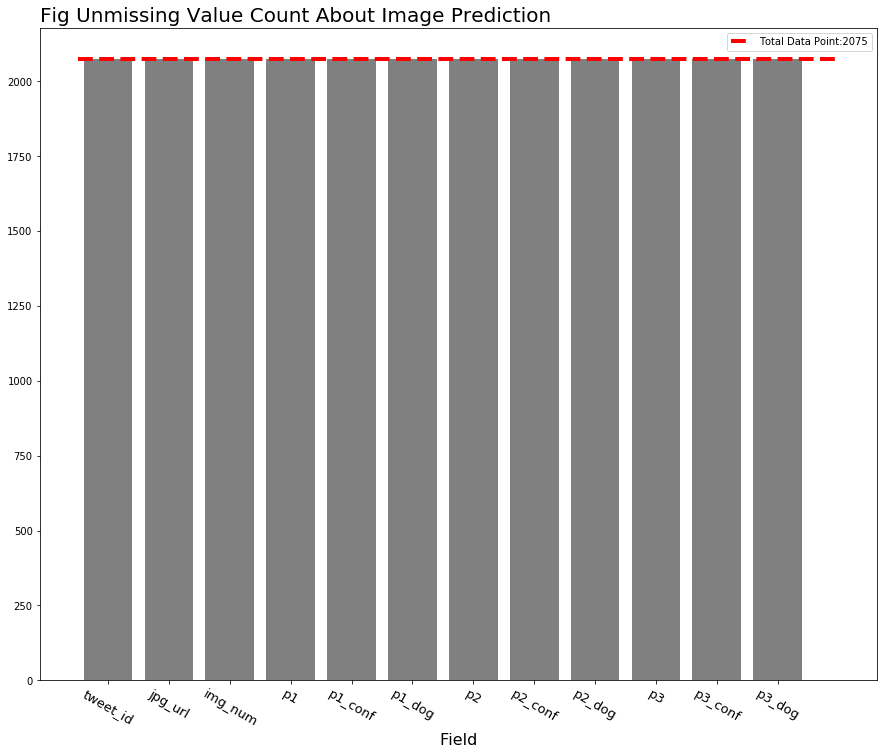

In [17]:
# plot the missing value hist plot
x_axis = image_prediction_data.columns.get_values()
height = image_prediction_data.count() - image_prediction_data.isnull().sum()

plt.figure(figsize=(15, 12))
plt.bar(np.arange(len(x_axis)), height, tick_label=x_axis, facecolor="grey", width=.8)
loc, labels = plt.xticks(rotation=330, fontsize=13)
plt.xlabel("Field", fontsize=16)

plt.hlines(y=2075, xmin=-0.5, xmax=loc.max()+1,colors="r", linestyles="--", linewidth=4,label="Total Data Point:2075")
plt.legend()
plt.title("Fig Unmissing Value Count About Image Prediction", loc="left", fontsize=20)
plt.show()

In [18]:
detect_data(twitter_archive_data, "twitter_archive_data")

The summary information:

There are 17 fiels and 2356 data points in the twitter_archive_data.

The missing_value information about the twitter_archive_data:

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64
The unique value about every field:

The tweet_id field with int64 dtype has unique values:

892420643555336193,
892177421306343426,
891815181378084864,
891689557279858688,
891327558926688256
-----------------------------------------

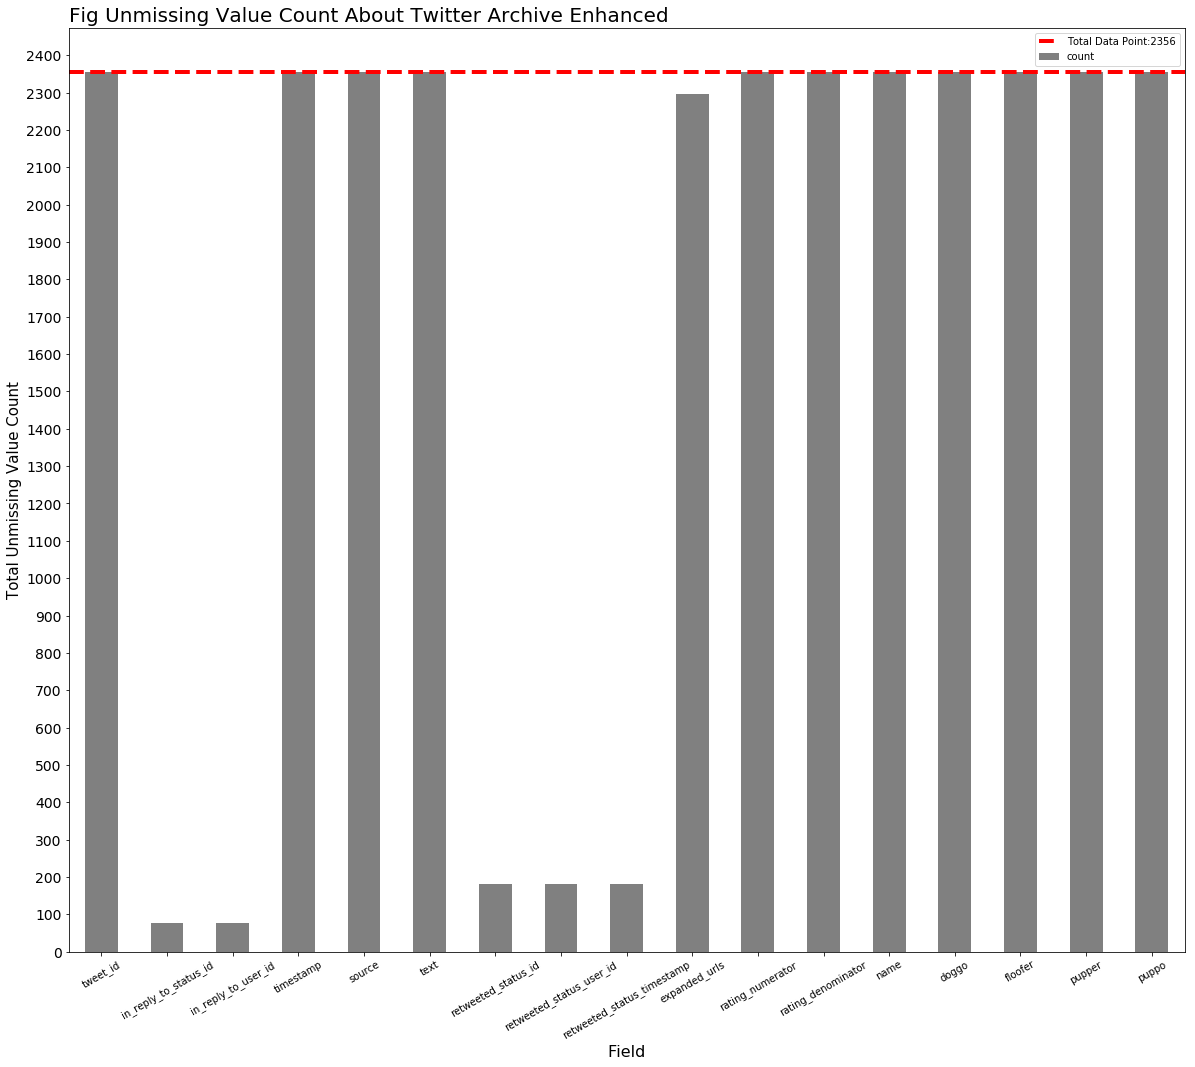

In [19]:
# plot the missing value hist plot
x_axis = twitter_archive_data.columns.get_values()
height = len(twitter_archive_data) - twitter_archive_data.isnull().sum()
hist_data = pd.DataFrame({"field": height.index.values, "count":height.values}, columns=["field", "count"])

hist_data.plot(x="field", kind="bar", figsize=(20, 17), rot=30, color="grey") #, yticks=np.arange(height.min()-500, height.max()+200, 300))
plt.xlabel("Field", fontsize=16)
loc, labels = plt.xticks( fontsize=10)
plt.ylabel("Total Unmissing Value Count", fontsize=15)
plt.yticks(np.arange(0, height.max()+200, 100), fontsize=14)
plt.title("Fig Unmissing Value Count About Twitter Archive Enhanced", loc="left", fontsize=20)

plt.hlines(y=2356, xmin=-0.5, xmax=loc.max()+1,colors="r",
           linestyles="--", linewidth=4,label="Total Data Point:2356")

plt.legend()
plt.show()

In [20]:
detect_data(tweet_data, "tweet_data")

The summary information:

There are 10 fiels and 2352 data points in the tweet_data.

The missing_value information about the tweet_data:

id                          0
created_at                  0
full_text                   0
media_url                 279
favorite_count              0
retweet_count               0
in_reply_to_status_id    2274
in_reply_to_user_id      2274
expanded_url              279
source                      0
dtype: int64
The unique value about every field:

The id field with int64 dtype has unique values:

892420643555336193,
892177421306343426,
891815181378084864,
891689557279858688,
891327558926688256
--------------------------------------------------------------------------------

The created_at field with object dtype has unique values:

Tue Aug 01 16:23:56 +0000 2017,
Tue Aug 01 00:17:27 +0000 2017,
Mon Jul 31 00:18:03 +0000 2017,
Sun Jul 30 15:58:51 +0000 2017,
Sat Jul 29 16:00:24 +0000 2017
--------------------------------------------------------------

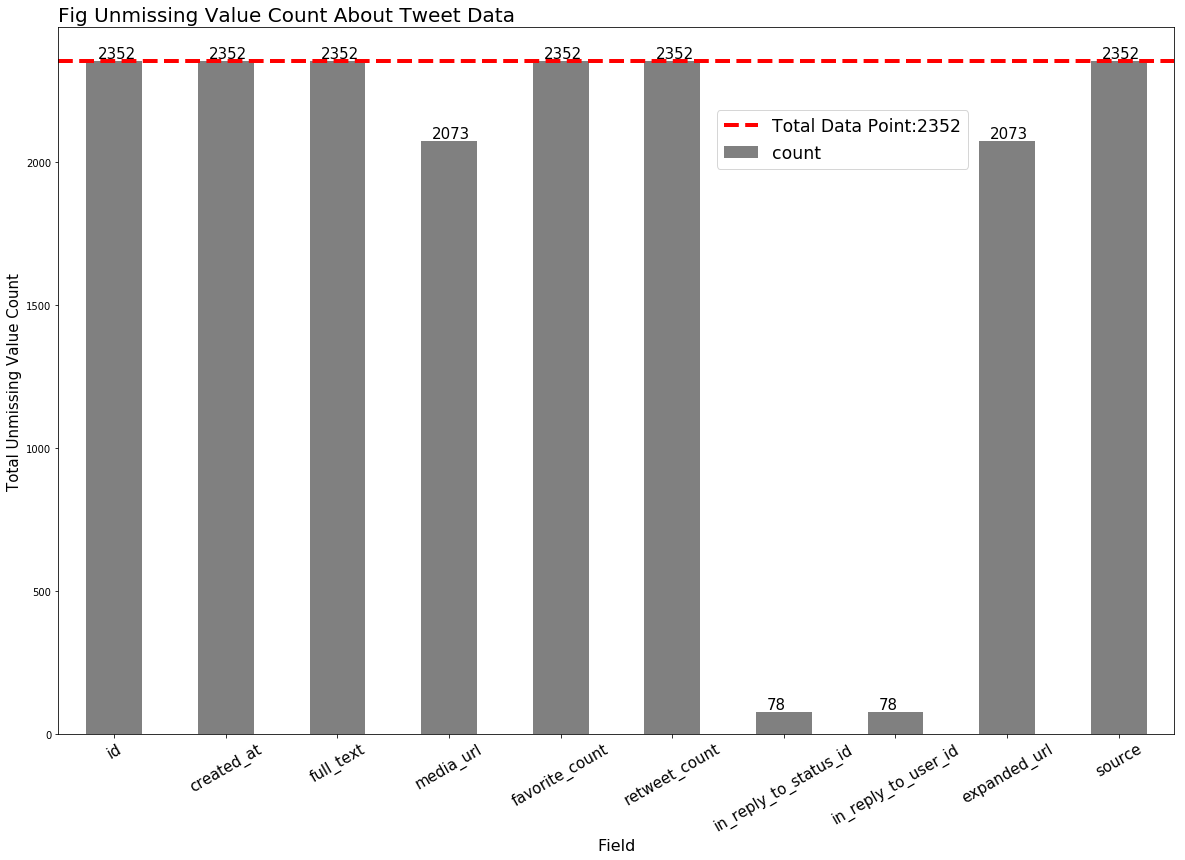

In [21]:
# plot the missing value hist plot
x_axis = tweet_data.columns.get_values()
height = len(tweet_data) - tweet_data.isnull().sum()
hist_data = pd.DataFrame({"field": height.index.values, "count":height.values}, columns=["field", "count"])

hist_data.plot(x="field", kind="bar", figsize=(20, 13), rot=30, color="grey", legend="") #, yticks=np.arange(height.min()-500, height.max()+200, 300))
plt.xlabel("Field", fontsize=16)
loc, label = plt.xticks( fontsize=10)
plt.ylabel("Total Unmissing Value Count", fontsize=15)
plt.yticks()
plt.xticks(fontsize=15)

for x, y, s in zip(loc, [i + 10 for i in height], [str(i) for i in height]):
    plt.text(x-0.15, y, s, fontsize=15)

plt.title("Fig Unmissing Value Count About Tweet Data", loc="left", fontsize=20)
plt.hlines(y=2352, xmin=-0.5, xmax=loc.max()+1,colors="r", linestyles="--", linewidth=4,label="Total Data Point:2352")
plt.legend(loc=(0.59,0.8), fontsize="xx-large")
plt.show()

### 参考
1. [Tweet object — Twitter Developers](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html) 该文档对 `API` 数据的 `Field` 进行了解释，需要注意和目前得到的数据存在部分差异